In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import seaborn as sbn
import sys 
import os

# Set global parameters 
pd.set_option("display.precision", 2)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the dataframes
path = os.path.join('result_dfs', 'df_sudokus_9x9_par.csv')
df_9x9_1000 = pd.read_csv(path )
df_9x9_1000.name = '9x9_1000'

# Make a list of which df's to parse (to make lists readable). Later we modify those dfs
list_dfs = [df_9x9_1000]

In [3]:
def parse_list(l):
    return list(map(int, l[1:-1].split(',')))
def parse_splits(x):
    if x=='[]':
        return 0
    else:
        return int(x)

for df in list_dfs:
    df.drop(columns=['Unnamed: 0'],inplace=True)
    columns_lists = df.filter(like='list').columns
    for column in columns_lists:
        df[column] = df[column].apply(parse_list)
    # we onky need to parse columns with splits for cdcl 
    columns_splits = df.filter(like='splits')
    for column in columns_splits.columns:
        df[column] = df[column].apply(parse_splits).astype(int)

In [4]:
# Print the summary statistics 
for df in list_dfs:
    print('Summary Statistics for: %s \n' % df.name)
    print(df.describe())

Summary Statistics for: 9x9_1000 

       DP_splits  DP_moms_splits  cdcl_splits  cdcl_moms_splits  \
count    1011.00         1011.00      1011.00           1011.00   
mean        7.35            6.68         5.89              5.95   
std        10.88           10.55         8.99             10.51   
min         0.00            0.00         0.00              0.00   
25%         1.00            1.00         1.00              1.00   
50%         4.00            4.00         3.00              3.00   
75%         9.00            8.00         7.00              7.00   
max       130.00          139.00        97.00            138.00   

       cdcl_chron_splits  cdcl_chron_moms_splits  sudoku_given_clauses  
count            1011.00                 1011.00               1011.00  
mean                6.17                    6.41                 24.86  
std                 8.23                    9.82                  1.26  
min                 0.00                    0.00                 21.0

### Visualization 

#### Plot the box plots for number of splits

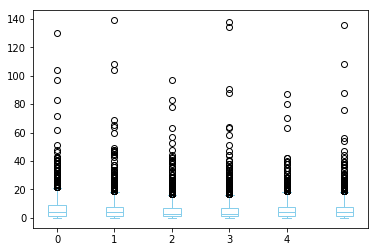

In [5]:
# With outliers

import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

def draw_plot(data, offset, edge_color, fill_color):
    """ offset parameter shift the box plot up or down """
    pos = np.arange(data.shape[1]) 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

for df in list_dfs:
    fig, ax = plt.subplots()
    data = df.filter(like='splits')
    draw_plot(data.values, 0, "skyblue", "white")
    plt.xticks(range(5))

    plt.show()
    plt.close()

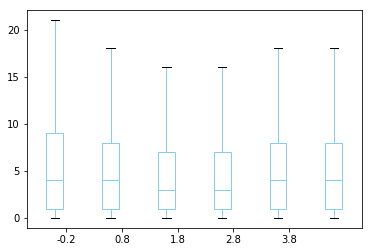

In [6]:
# With outliers

import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True,showfliers=False, manage_xticks=True)
    for element in ['boxes', 'whiskers', 'medians']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

for df in list_dfs:
    fig, ax = plt.subplots()
    data = df.filter(like='splits')
    draw_plot(data.values, -0.2, "skyblue", "white")
    plt.xticks(range(5))

    plt.show()
    plt.close()

#### Plot the number of 'total' satisfied split per run 

In [7]:
# Print 'total' number of satisfied clauses per split
#     * Select n number of splits to visualize, say n = 200

n = 2000 # need all splits
total_sat_clauses_dict = dict()

for df in list_dfs:
    df_sat_clauses = pd.DataFrame(index=list(df.index))
    columns_lists = df.filter(like='list').columns 
    for column in columns_lists:
        array = list(map(list,df[column].values.tolist()))
        matrix = np.full([n], np.nan)
        for row in array:
            # limit the number of splits taken for evalaution=taking-the-mean/taking-the-sum
            n_fill_in = ((n - len(row))>0)*(n - len(row)) or 0
            array_modified = np.hstack((np.array(row[:n]) , np.full([n_fill_in],np.nan)))
            matrix = np.vstack((matrix, array_modified))
    
        # take the average for each column in matrix to arrive to avg # of sat clauses for that split=column
        sum_array = np.nansum(matrix, axis=1)
        df_sat_clauses[column] = sum_array[1:]
    total_sat_clauses_dict[df.name] = df_sat_clauses 


In [8]:
# Print the summary statistics 
for k,df in total_sat_clauses_dict.items():
    print('Summary Statistics for: %s \n' % k)
    print(df.describe())
    
# total_sat_clauses_dict['9x9_1000']

Summary Statistics for: 9x9_1000 

       DP_list_sat_clauses  DP_moms_list_sat_clauses  cdcl_list_sat_clauses  \
count              1011.00                   1011.00                1011.00   
mean              13298.43                  13157.28               13952.79   
std                2421.00                   2249.20                3641.32   
min               12008.00                  12008.00               12008.00   
25%               12012.00                  12012.00               12012.00   
50%               12426.00                  12385.00               12647.00   
75%               13549.50                  13325.50               14375.00   
max               40063.00                  38741.00               53784.00   

       cdcl_moms_list_sat_clauses  cdcl_chron_list_sat_clauses  \
count                     1011.00                      1011.00   
mean                     14063.51                     13168.26   
std                       4539.43                      

#### Plot the number of satisfied clauses per split 

In [16]:
# Print average number of satisfied clauses per split
#     * Select n number of splits to visualize, say n = 200
n = 220
avg_sat_clauses_dict = dict()

for df in list_dfs:
    df_sat_clauses = pd.DataFrame(index=list(range(n)))
    columns_lists = df.filter(like='list').columns 
    for column in columns_lists:
        array = list(map(list,df[column].values.tolist()))
        matrix = np.full([n], np.nan)
        for row in array:
            # limit the number of splits taken for evalaution=taking-the-mean
            n_fill_in = ((n - len(row))>0)*(n - len(row)) or 0
            array_modified = np.hstack((np.array(row[:n]) , np.full([n_fill_in],np.nan)))
            matrix = np.vstack((matrix, array_modified))
    
        # take the average for each column in matrix to arrive to avg # of sat clauses for that split=column
        avg_array = np.nanmean(matrix, axis=0)
        df_sat_clauses[column] = avg_array
    avg_sat_clauses_dict[df.name] = df_sat_clauses 


In [17]:
# try the logarithm to better visialize  ===== !!! =====

# Run only once (!)
for column in avg_sat_clauses_dict['9x9_1000'].columns:
    avg_sat_clauses_dict['9x9_1000'][column] = np.log(avg_sat_clauses_dict['9x9_1000'][column])


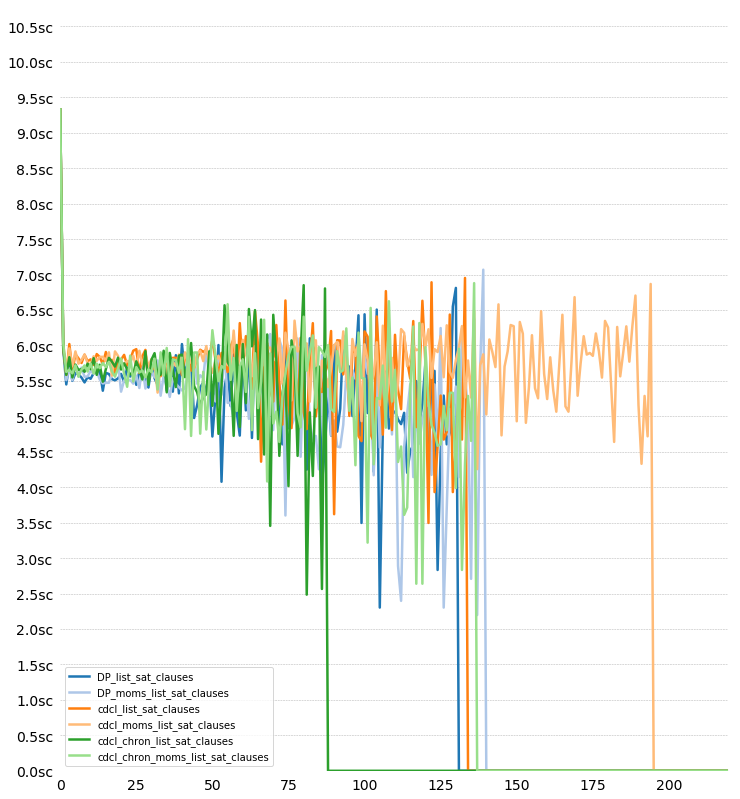

In [18]:
import matplotlib.pyplot as plt  
import pandas as pd  

# Read the data into a pandas DataFrame.  
df = avg_sat_clauses_dict['9x9_1000']

# visualization wont work with nans
df = df.fillna(value=0.0)

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    

# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

max_sat_clauses = df.max().max() + df.std().max()/2
# n = 400
y_step = 0.5

# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, max_sat_clauses)    
plt.xlim(0, n)    

# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(np.arange(0, max_sat_clauses, y_step), [str(x) + "sc" for x in np.arange(0, max_sat_clauses, y_step)], fontsize=14)    
plt.xticks(fontsize=14)    

# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in np.arange(0, max_sat_clauses, y_step):    
    plt.plot(np.arange(0, n), [y] * len(np.arange(0, n)), "--", lw=0.5, color="black", alpha=0.3)    

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    

# Get the names for the legend    
majors = list(df.columns)

for rank, column in enumerate(majors):    
    # Plot each line separately with its own color, using the Tableau 20    
    # color set in order.    
    plt.plot(df.index.values,    
            df[column.replace("\n", " ")].values,    
            lw=2.5, color=tableau20[rank], label = column)    

# you can set the location with addin loc param i.e. loc='upper right'
plt.legend()   
